### Variational hamiltonian ansatz for TFI, (transverse field ising)
Exchange packages Qiskit to QLM to Cirq

In this notebook we use 3 quantum programming languages, Qiskit, QLM and Cirq to calculate the ground state energy of transverse ising model.

We also make use of the myQLM library to exchange between the programming languages packages.

We start with qiskit then qlm and finally cirq.

### Outline
<ol>
    <li>Introduction</li>
    <li>Building the hamiltonian</li>
    <li>Building the variational hamiltonian ansatz</li>
    <li>Energy calculation using Qiskit</li>
    <li>Energy calculation using QLM</li>
    <li>Energy calculation using Cirq</li>
    <li>Conclusion</li>
    <li>References</li>
</ol>

### 1. introduction:

The transverse-field Ising (TFI) model is a prototypical model of a quantum magnet, where quantum fluctuations are used to generate paramagnetism instead of temperature. Another common name is ‘quantum Ising model’, or ’transverse Ising model’ (TIM).

We will use the Variational hamiltonian ansatz that has several advantages over other ansatz types:

<ul>
    <li>Less affected by barren plateaus compared to other types of ansatz</li>
    <li>Converges better and faster</li>
</ul>

This ansatz is the same as the evolved operator ansatz in qiskit but with one difference. The operator is split into smaller groups/operators were each group contains terms that commute with each other.

### 2. Building the hamiltonian

The following is the equation for 2 qubits, we will extend it and perform for 6 qubits instead.

$\hat H = -\hat\sigma^z_0 \otimes \hat\sigma^z_1 - h(\hat\sigma^x_0  + \hat\sigma^x_1).$

In [1]:
from qiskit.opflow import X, Y, Z, I
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.quantum_info import SparsePauliOp, PauliList

C:\Users\mhhou\AppData\Local\Temp\ipykernel_21700\1362777275.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I


Build the full hamiltonian for 6 qubits before splitting.
We will assume that only qubits near each other interact, like 0-1, 1-2, 2-3, ...

In [2]:
h = 0.25
H = SparsePauliOp.from_list([("ZZIIII", -1), ("IZZIII", -1), ("IIZZII", -1), ("IIIZZI", -1), ("IIIIZZ", -1), ("XIIIII", -h), ("IXIIII", -h), ("IIXIII", -h), ("IIIXII", -h), ("IIIIXI", -h), ("IIIIIX", -h)])

In [3]:
H.num_qubits

6

Now we split the hamiltonian into commuting groups, we can see that we got 2 groups.

In [4]:
H.group_commuting()

[SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ'],
               coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j]),
 SparsePauliOp(['IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'XIIIII', 'IIIIIX'],
               coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j])]

### 3. Building the hamiltonian variational ansatz

The following circuit is for that of the hamiltonian before splitting.

In [5]:
qc = EvolvedOperatorAnsatz(operators=H, reps=2)

c:\Users\mhhou\.conda\envs\openvqa\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


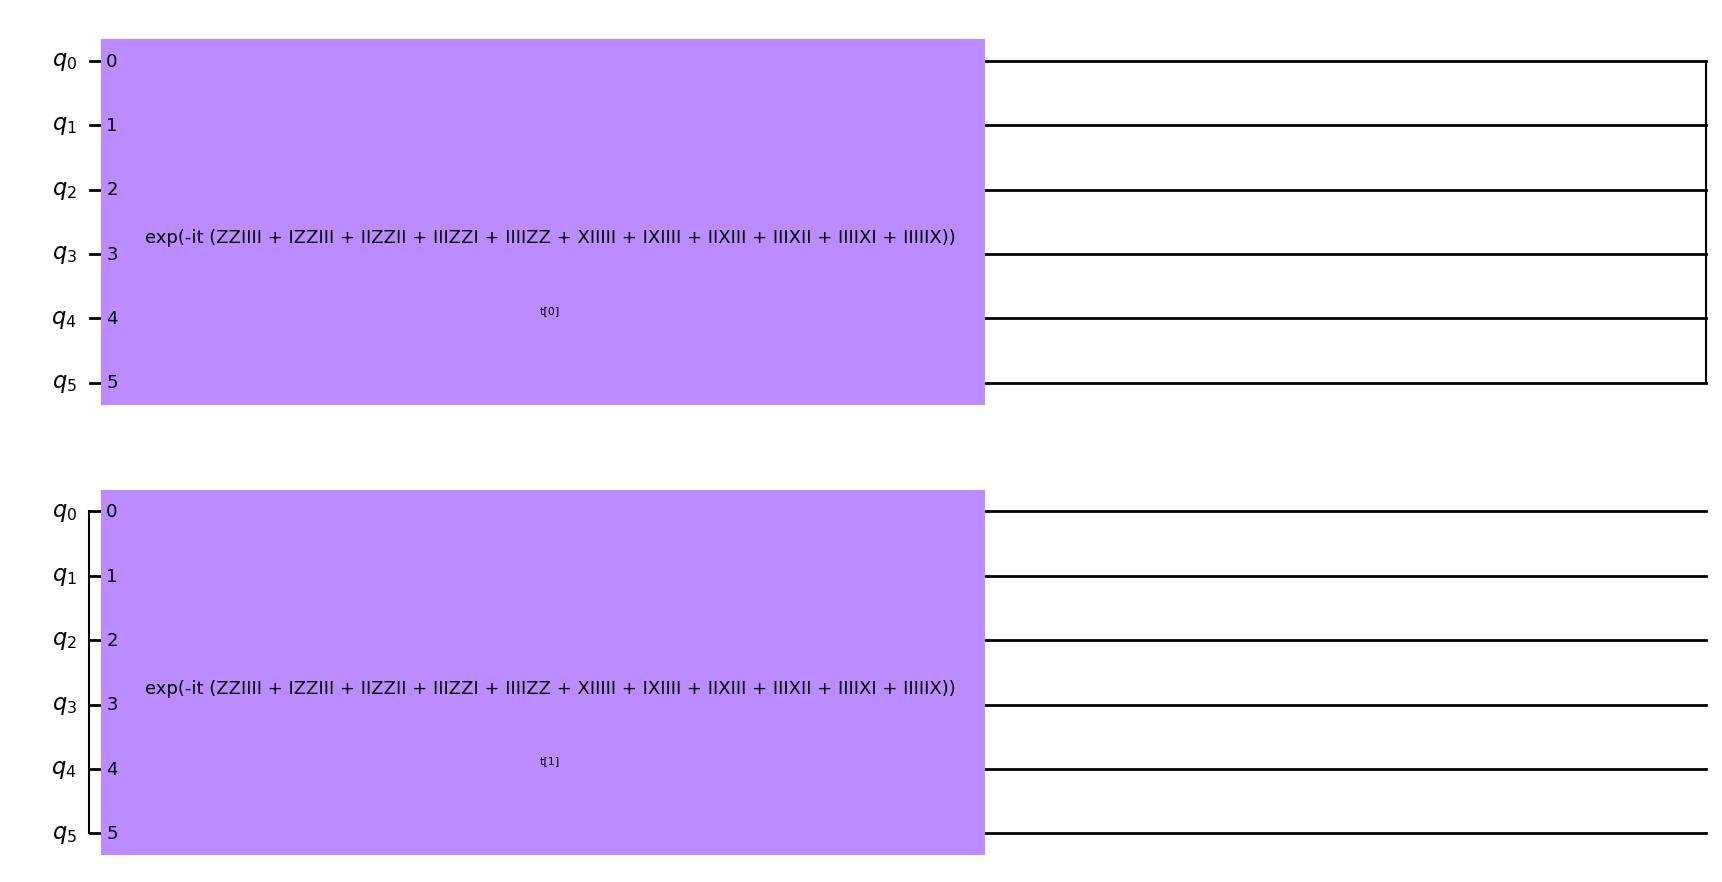

In [6]:
qc.decompose().draw('mpl')

The following circuit is for that of the hamiltonian after splitting.

In [7]:
qc = EvolvedOperatorAnsatz(operators=H.group_commuting(), reps=2)

c:\Users\mhhou\.conda\envs\openvqa\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


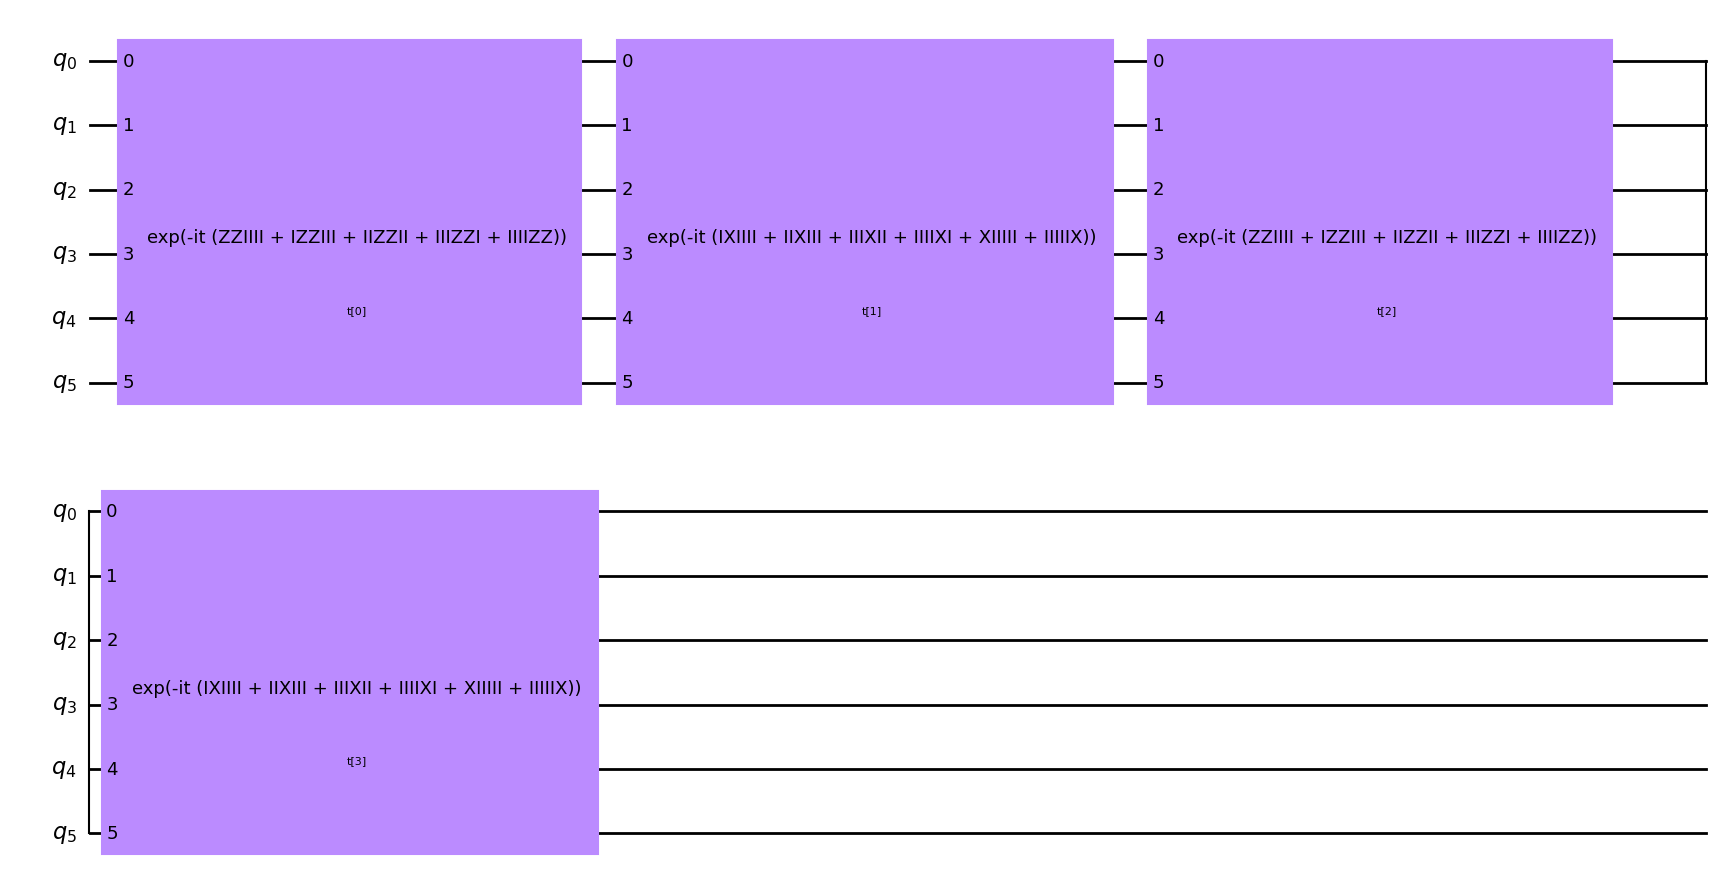

In [8]:
qc.decompose().draw('mpl')

We now transpile the circuit into basis gates supported by the myqlm package to be able to transform the circuit from qiskit to qlm to cirq.

In [9]:
from qiskit.compiler import transpile

basis_gates = ['rx', 'u2', 'cx', 'ry', 'h', 'rz', 'x', 'y', 'z']

qc_trans = transpile(qc, basis_gates=basis_gates)

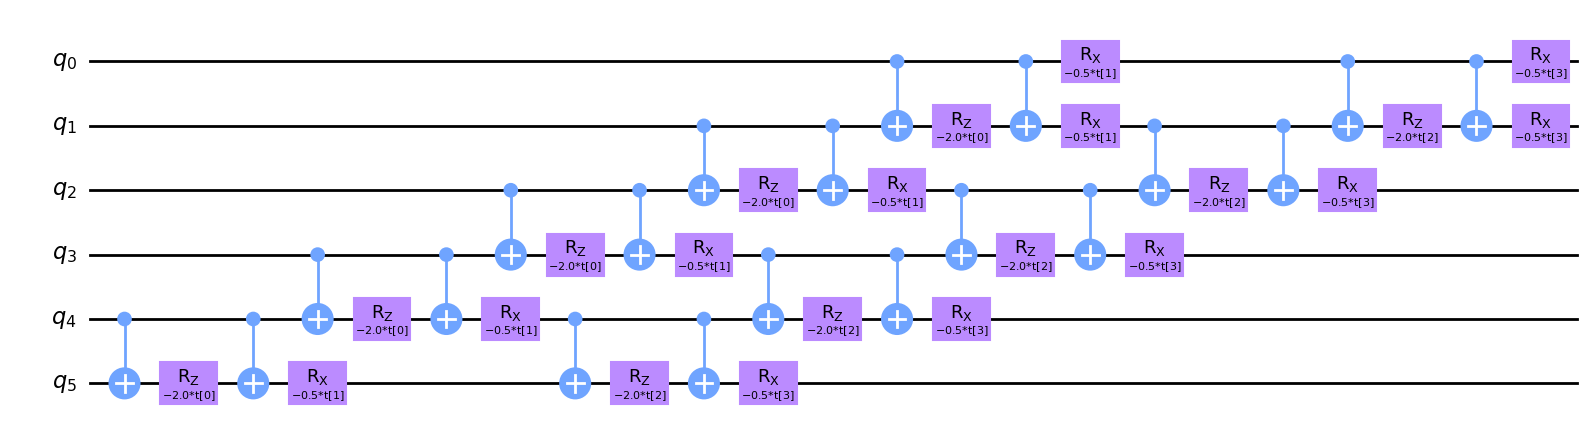

In [10]:
qc_trans.draw('mpl')

### 4. Energy calculation using qiskit

We define a function to store the values at each iteration.

In [11]:
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

We define now the estimator and the optimizer.

In [12]:
from qiskit.primitives import Estimator

estimator = Estimator()

In [13]:
from qiskit_algorithms.optimizers import SPSA
optimizer = SPSA(maxiter=100)

The ground state energy is computed using vqe for this ansatz.

In [14]:
from qiskit_algorithms import VQE

vqe = VQE(estimator, qc_trans, optimizer, callback=store_intermediate_result)

In [15]:
result = vqe.compute_minimum_eigenvalue(H)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': np.float64(-5.091687343529591),
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000294DDC70BB0>,
    'optimal_parameters': {   ParameterVectorElement(t[0]): np.float64(-1.8393638095693994),
                              ParameterVectorElement(t[1]): np.float64(-0.2612505705377666),
                              ParameterVectorElement(t[2]): np.float64(2.7141084247940013),
                              ParameterVectorElement(t[3]): np.float64(-0.0052084051925541195)},
    'optimal_point': array([-1.83936381, -0.26125057,  2.71410842, -0.00520841]),
    'optimal_value': np.float64(-5.091687343529591),
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x00000294DDC58A30>,
    'optimizer_time': 0.8561728000640869}


Text(0.5, 1.0, 'Convergence with no noise')

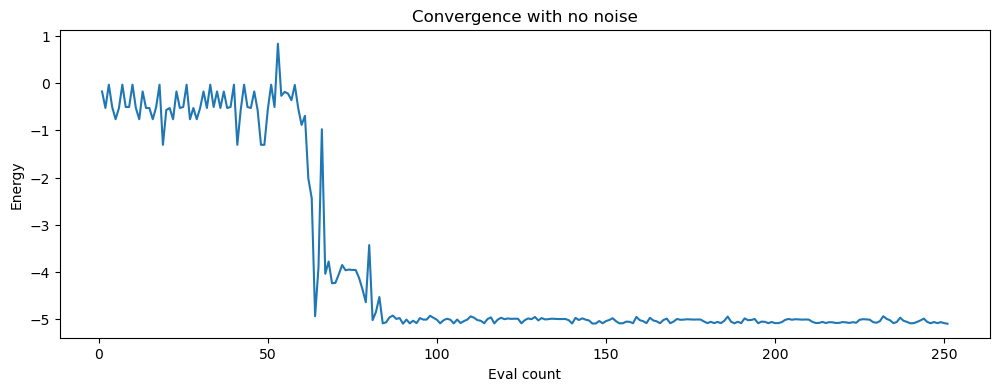

In [16]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

### 5. Energy calculation using qlm

First, the qiskit transpiled circuit of the variational hamiltonian ansatz is transformed into qlm.

In [17]:
from qat.lang import *
from qat import *
from qat.interop.qiskit import qiskit_to_qlm

qlm_circuit = qiskit_to_qlm(qc_trans)

AttributeError: module 'numpy' has no attribute 'ComplexWarning'

We can see in the next cell that we maintain the number of variables after circuit type transformation.

In [18]:
qlm_circuit.get_variables()

['t[0]', 't[1]', 't[2]', 't[3]']

It is required to rebuild the hamiltonian using qlm to work with the qlm circuit.

In [19]:
from qat.core import Observable, Term

my_observable = Observable(6, # A 6 qubits observable
                           pauli_terms=[
                               Term(-h, 'XIIIII', [0, 1, 2, 3, 4, 5]),
                               Term(-h, 'IXIIII', [0, 1, 2, 3, 4, 5]),
                               Term(-h, 'IIXIII', [0, 1, 2, 3, 4, 5]),
                               Term(-h, 'IIIXII', [0, 1, 2, 3, 4, 5]),
                               Term(-h, 'IIIIXI', [0, 1, 2, 3, 4, 5]),
                               Term(-h, 'IIIIIX', [0, 1, 2, 3, 4, 5]),
                               Term(-1, 'ZZIIII', [0, 1, 2, 3, 4, 5]),
                               Term(-1, 'IZZIII', [0, 1, 2, 3, 4, 5]),
                               Term(-1, 'IIZZII', [0, 1, 2, 3, 4, 5]),
                               Term(-1, 'IIIZZI', [0, 1, 2, 3, 4, 5]),
                               Term(-1, 'IIIIZZ', [0, 1, 2, 3, 4, 5])
                           ],
                           constant_coeff=0)
print(my_observable)

-0.25 * (X|[0]) +
-0.25 * (X|[1]) +
-0.25 * (X|[2]) +
-0.25 * (X|[3]) +
-0.25 * (X|[4]) +
-0.25 * (X|[5]) +
-1 * (ZZ|[0, 1]) +
-1 * (ZZ|[1, 2]) +
-1 * (ZZ|[2, 3]) +
-1 * (ZZ|[3, 4]) +
-1 * (ZZ|[4, 5])


It is time to run the vqe in qlm and see if we get same result as in qiskit vqe.

In [20]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import numpy as np

nqbits = 4
job = qlm_circuit.to_job(job_type="OBS",
                  observable=my_observable,
                  nbshots=0)

theta_0 = np.random.random(size=4)

linalg_qpu = get_default_qpu()
methods = ["COBYLA", "Nelder-Mead", "BFGS"]
result = {}
for method in methods:
    optimizer_scipy = ScipyMinimizePlugin(method=method,
                                          tol=1e-6,
                                          options={"maxiter": 200},
                                          x0=theta_0)
    qpu = optimizer_scipy | linalg_qpu
    result[method] = qpu.submit(job)

    print("Minimum VQE energy (%s) = %s"%(method, result[method].value))

C:\Users\husse\anaconda3\envs\openVQE3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Minimum VQE energy (COBYLA) = -5.09186786237472
Minimum VQE energy (Nelder-Mead) = -5.091870515231543
Minimum VQE energy (BFGS) = -5.091870515231432


Happily, we got the same results, and it is now time for plotting the results for different optimizers.

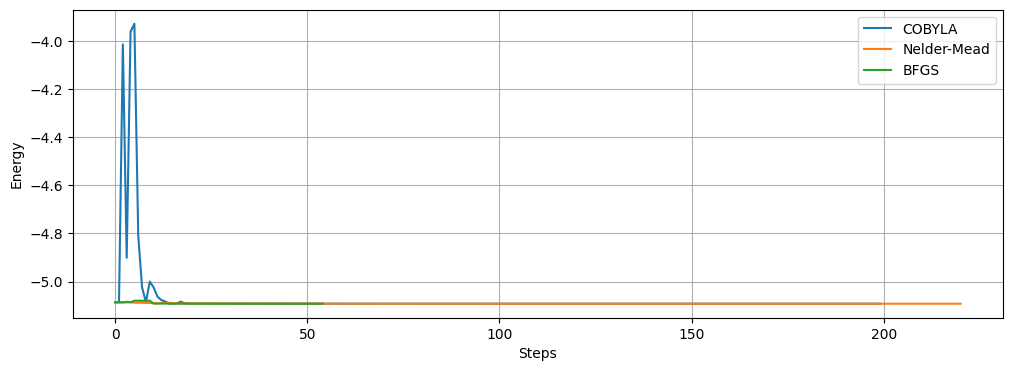

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
for method in methods:
    plt.plot(eval(result[method].meta_data['optimization_trace']),
             label=method)
plt.grid()
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy");

### 6. Energy calculation using cirq

As we have done previously, we transform the qlm circuit to a cirq circuit.

In [22]:
from qat.interop.cirq import qlm_to_cirq
cirq_circuit = qlm_to_cirq(qlm_circuit)
#print(cirq_circuit)

We now define 2 arrays for storing the energies and parameters.

In [23]:
import random
energies = []
random_params = []

Now we define the simulator in cirq.

In [24]:
import cirq

simulator = cirq.Simulator()

Now we define the observable.

In [25]:
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)
q3 = cirq.LineQubit(3)
q4 = cirq.LineQubit(4)
q5 = cirq.LineQubit(5)
q6 = cirq.LineQubit(6)

pauli_terms=[
                -1*cirq.Z(q1)*cirq.Z(q2),
                -1*cirq.Z(q2)*cirq.Z(q3),
                -1*cirq.Z(q3)*cirq.Z(q4),
                -1*cirq.Z(q4)*cirq.Z(q5),
                -1*cirq.Z(q5)*cirq.Z(q6),
                -h*cirq.X(q1),
                -h*cirq.X(q2),
                -h*cirq.X(q3),
                -h*cirq.X(q4),
                -h*cirq.X(q5),
                -h*cirq.X(q6)
                           ]

observable = sum(pauli_terms)

Now we perform 1000 iterations of sweep.
We performed random choosing of parameters in each step which is somehow similar to sweep but not exactly as sweep.

In [26]:
for i in range(1000):
    # Generate a list of 4 random values between -1 and 1
    x = [2 * random.random() - 1 for _ in range(4)]
    resolver = cirq.ParamResolver({'t[0]': x[0], 't[1]': x[1], 't[2]': x[2], 't[3]': x[3]})
    resolved_circuit = cirq.resolve_parameters(cirq_circuit, resolver)

    ev_list = simulator.simulate_expectation_values(
        cirq.Circuit(resolved_circuit), observables=[observable], permit_terminal_measurements=True
    )
    energies.append(ev_list[0].real)
    random_params.append(x)

In [27]:
print("The minimum energy found is ", min(energies))

The minimum energy found is  -5.0000011920928955


### 7. Conclusion:
<ul>
    <li>The hamiltonian variational ansatz was transformed successfully from qiskit to qlm to cirq</li>
    <li>One big advantage is that if cirq or qlm does not implement this ansatz, we implement it in qiskit then transform to qlm or cirq.</li>
    <li>We were able to find the same energy in 3 different languages.</li>
</ul>


### 8. References

<ol>
    <li>QLM VQE tutorial: <a href="https://notebooks.gesis.org/binder/jupyter/user/myqlm-myqlm-notebooks-fywdbybe/notebooks/tutorials/variational_algorithms/vqe_getting_started_random_spin.ipynb">link</a></li>
    <li>Qiskit Operators: <a href="https://qiskit-org-web-resources.s3.us.cloud-object-storage.appdomain.cloud/documentation/stable/0.19/tutorials/circuits_advanced/2_operators_overview.html">link</a></li>
    <li>Qiskit VQE: <a href="https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html">link</a></li>
    <li>Qiskit hamiltonian variational ansatz: <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.hamiltonian_variational_ansatz">link</a></li>
    <li>cirq sweep: <a href="https://quantumai.google/cirq/simulate/params">link</a></li>
</ol>